NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets
This coursework will involve you implementing functions for a text classifier, which you will train to identify the sentiment expressed in a text in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file NLP_Assignment_1_Instructions.pdf for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all ipython notebooks and extra resources you need to run the code if you've added them in the code submission, and a 2 page report (pdf) in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.


In [51]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.util import ngrams
from sklearn.metrics import classification_report
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [52]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

Input and Basic preprocessing

In [53]:
def parse_data_line(data_line):
    #Should return a tuple of the label as just positive or negative and the statement
    #e.g. (label, statement)
    label = data_line[1]
    text = data_line[2]

    return (label, text)



Here, parse_data_line takes a line of tab separated text data and extracts the label and text from the line and then it returns a tuple containing the simplified labels i.e positive or negative and the text

In [54]:
def pre_process(text):
    #Separate punctuation at ends of strings
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    #Separate punctuation at the beginning of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)

    #Tokenizing using NLTK
    tokens = word_tokenize(text)

    #Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [t.lower() for t in tokens if t.lower() not in stop_words]

    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return tokens

# Test
text = "I am a student at Queen Mary University of London."
preprocessed_tokens = pre_process(text)
print(preprocessed_tokens)

['student', 'queen', 'mary', 'university', 'london', '.']


Here, we define a pre_process function which takes a string as inpput and performs several text preprocessing steps such as
1. Punctuation separation
2. Tokenization
3. Stopword Removal
4. Lemmatization

Basic Feature Extraction

In [55]:
global_feature_dict = {}  # A global dictionary of features

def to_feature_vector(tokens, use_binary=True, include_stylistic=True, include_bigrams=True):
    #Should return a dictionary containing features as keys, and weights as values

    #Dictionary to represent feature_vector
    feature_vector = {}

    #Counter to count the occurrences of each token
    token_counts = Counter(tokens)

    #Updating the global feature dictionary with the tokens from the current text
    global_feature_dict.update(token_counts)

    #Setting feature values based on the chosen scheme
    for token, count in token_counts.items():
        if use_binary:
            feature_vector[token] = 1
        else:
            feature_vector[token] = count  # Use term frequency as feature weight

    #Add extra stylistic features
    if include_stylistic:
        words_per_sentence = len(tokens) / tokens.count('.') if tokens.count('.') > 0 else len(tokens)
        feature_vector['words_per_sentence'] = words_per_sentence

    # Add bigrams
    if include_bigrams:
        bigrams = list(ngrams(tokens, 2))
        for bigram in bigrams:
            feature_vector[' '.join(bigram)] = 1

    return feature_vector

# Test
text = "I study at QMUL in London. It is a great university."
preprocessed_tokens = pre_process(text)
result = to_feature_vector(preprocessed_tokens, use_binary=False, include_stylistic=True)
print(result)

{'study': 1, 'qmul': 1, 'london': 1, '.': 2, 'great': 1, 'university': 1, 'words_per_sentence': 3.5, 'study qmul': 1, 'qmul london': 1, 'london .': 1, '. great': 1, 'great university': 1, 'university .': 1}


Here, we define to_feature_vector function that transforms a list of preprocessed tokens into a dictionary representing a feature vector. This function takes several parameters to custtomize the feature extraction process
1. use_binary- if set to True, binary values are used as features and if set to False then term frequency is used as feature weight
2. include_stylistic- if set to True, additional stylistic features are added to the feature vector. In our case, avg number of words per sentence
3. include_bigrams- if set to True, bigrams are included as features with a binary representation
The function utilizes a global dictionary(global_feature_dict) to keep track of token occurrences across diff texts

In [56]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC(max_iter=100000))])
    return SklearnClassifier(pipeline).train(data)



Cross-validation

In [57]:

def cross_validate(dataset, folds):
    cv_results = {'precision': 0, 'recall': 0, 'f1-score': 0, 'accuracy': 0}
    fold_size = int(len(dataset) / folds) + 1

    for i in range(0, len(dataset), int(fold_size)):
        print("Fold start on items %d - %d" % (i, i + fold_size))

        #Split the dataset into training and test sets
        train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)

        #Train the classifier
        classifier = train_classifier(train_data)

        #Preprocess the test data
        preprocessed_test_data = [text for text, label in test_data]

        #True labels
        test_labels = [label for text, label in test_data]

        #Predict labels using classifier
        predicted_labels = predict_labels(preprocessed_test_data, classifier)

        #Evaluate the classifier
        report = classification_report(test_labels, predicted_labels, output_dict=True)

        #Add the results for this fold to the overall results
        cv_results['precision'] += report['weighted avg']['precision']
        cv_results['recall'] += report['weighted avg']['recall']
        cv_results['f1-score'] += report['weighted avg']['f1-score']
        cv_results['accuracy'] += report['accuracy']

    #Calculating average scores
    num_folds = min(folds, len(dataset))
    cv_results = {key: value / num_folds for key, value in cv_results.items()}

    return cv_results

Here, we define a cross validation function called cross_validate to evaluate the performance of a classifier on a dataset using the k fold cross validation. It iterates over the folds and splitting the dataset into training and test sets for each iteration
the classifier is trained on the training data and then tested on the test data
The evaluation metrics (precision, recall, f1-score, acccuracy) for each fold are aggregate and the avg scores are calculated and returned as a dictionary

In [58]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)
# reviewSample
def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(sample)))

In [59]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
57608


In [60]:
pred= cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented
print(pred)

Fold start on items 0 - 2684
Training Classifier...
Fold start on items 2684 - 5368
Training Classifier...
Fold start on items 5368 - 8052
Training Classifier...
Fold start on items 8052 - 10736
Training Classifier...
Fold start on items 10736 - 13420
Training Classifier...
Fold start on items 13420 - 16104
Training Classifier...
Fold start on items 16104 - 18788
Training Classifier...
Fold start on items 18788 - 21472
Training Classifier...
Fold start on items 21472 - 24156
Training Classifier...
Fold start on items 24156 - 26840
Training Classifier...
{'precision': 0.8602440361641175, 'recall': 0.8617477175330726, 'f1-score': 0.8601676040026278, 'accuracy': 0.8617477175330726}


Error Analysis

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.71      0.76      4576
    positive       0.86      0.92      0.89      8840

    accuracy                           0.85     13416
   macro avg       0.84      0.81      0.82     13416
weighted avg       0.84      0.85      0.84     13416

Training Classifier...


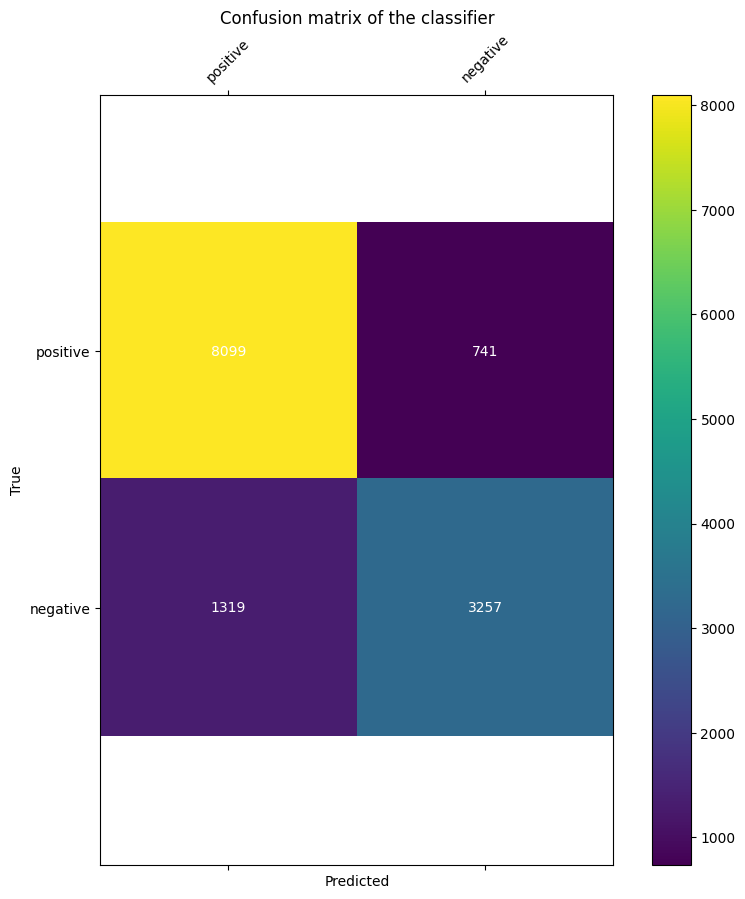

In [61]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

    # Quantitative analysis and observations
report = classification_report([label for text, label in test_data_first_fold], predicted, target_names=['negative', 'positive'])
print("Classification Report:")
print(report)

# Separate test data into False Positives and False Negatives
false_positives = []
false_negatives = []

for i, (text, true_label) in enumerate(test_data_first_fold):
    predicted_label = predicted[i]
    if predicted_label != true_label:
        instance_info = f"Text: {text}\nTrue Label: {true_label}\nPredicted Label: {predicted_label}\n"
        if predicted_label == 'positive' and true_label == 'negative':
            false_positives.append(instance_info)
        elif predicted_label == 'negative' and true_label == 'positive':
            false_negatives.append(instance_info)

# Print or write to a file
with open('false_positives.txt', 'w') as fp_file:
    fp_file.write("\n".join(false_positives))

with open('false_negatives.txt', 'w') as fn_file:
    fn_file.write("\n".join(false_negatives))

folds=len(train_data)//2
# train1,train2=zip(*train_data[:folds])
# test1,test2=zip(*train_data[folds:])

train_data_first_fold = train_data[:folds]
test_data_first_fold = train_data[folds:2*folds]
# Take one fold data and run confusion matrics function - TBD
predicted=predict_labels([text for text, label in test_data_first_fold],train_classifier(train_data_first_fold))
confusion_matrix_heatmap([label for text, label in test_data_first_fold], predicted, labels=['positive', 'negative'])

Optimising pre-processing and feature extraction

In [46]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'tomorrow': 1, "'": 1, 'release': 1, '58th': 1, 'episode': 1, '#': 1, 'hsonair': 1, 'profiling': 1, '@': 1, 'alissadossantos': 1, '!': 1, 'talk': 1, 'storytelling': 1, 'beyonce': 1, 'words_per_sentence': 16, "tomorrow '": 1, "' release": 1, 'release 58th': 1, '58th episode': 1, 'episode #': 1, '# hsonair': 1, 'hsonair profiling': 1, 'profiling @': 1, '@ alissadossantos': 1, 'alissadossantos !': 1, "! '": 1, "' talk": 1, 'talk storytelling': 1, 'storytelling beyonce': 1, 'beyonce !': 1}, 'positive')
Training Classifier...
Done training!
Precision: 0.858851
Recall: 0.860316
F Score:0.858566
